In [4]:
import os
from pathlib import Path
from glob import glob

import pandas as pd

from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, f1_score

from deeppavlov.dataset_readers.paraphraser_reader import ParaphraserReader
from deeppavlov.dataset_readers.basic_classification_reader import BasicClassificationDatasetReader

from utils import STSReader, XNLIReader

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# notebook parameters
input_dir = 'predictions'

In [7]:
paraphraser = ParaphraserReader().read(Path.cwd() / 'data/Paraphraser')

msrvid = STSReader().read(Path.cwd() / 'data/STS2012_MSRvid_translated',
                          input_fname='STS.input.MSRvid.txt',
                          labels_fname='STS.gs.MSRvid.txt')

xnli = XNLIReader().read(Path.cwd() / 'data/XNLI-1.0', lang='ru')

rusentiment = BasicClassificationDatasetReader().read(
                Path.cwd() / 'data/Rusentiment',
                train='rusentiment_preselected_posts.csv',
                test='rusentiment_test.csv',
                x='text',
                y='label')

sberfaq = BasicClassificationDatasetReader().read(
                Path.cwd() / 'data/SBER_FAQ',
                train='sber_faq_train.csv',
                valid='sber_faq_valid.csv',
                test='sber_faq_test.csv',
                names=['label', 'text'],
                sep='\t',
                x='text',
                y='label')

dir2data = {'paraphraser': paraphraser,
            'msrvid': msrvid,
            'xnli': xnli,
            'rusentiment': rusentiment,
            'sberfaq': sberfaq}

score_tasks = ['paraphraser', 'msrvid']

2018-11-06 17:49:15.607 WARNING in 'deeppavlov.dataset_readers.basic_classification_reader'['basic_classification_reader'] at line 97: Cannot find /home/not_a_robot/Documents/sent_embeddings/comparator/data/Rusentiment/valid.csv file
2018-11-06 17:49:16.426 WARNING in 'deeppavlov.dataset_readers.basic_classification_reader'['basic_classification_reader'] at line 97: Cannot find /home/not_a_robot/Documents/sent_embeddings/comparator/data/SBER_FAQ/sber_faq_valid.csv file


In [34]:
dir2data = {'paraphraser': paraphraser,  # f1 from cosine
            'msrvid': msrvid,            # correlation from cosine
            'xnli': xnli,                # f1 from class
            'rusentiment': rusentiment,  # f1 from class
            'sberfaq': sberfaq}          # f1 from class

tasks = dir2data.keys()

In [16]:
def score_sts(preds_str, dataset):
    preds = [float(p) for p in preds_str]
    true_ = [p[2] for p in msrvid['test']]
    return {'pearson correlation': pearsonr(preds, true_)}


def score_paraphraser(preds_str, dataset):
    preds = [float(p) for p in preds_str]
    true_ = [int(p[2] != -1) for p in paraphraser['test']]
    # TODO: threshold search
    return {'accuracy': accuracy_score(true_, preds),
            'f1': f1_score(true_, preds)}


def score_clf(preds_str, dataset):
    preds = preds_str
    true_ = [p[1] for p in dataset['test']]
    return {'accuracy': accuracy_score(preds_str)}

In [ ]:
input_dir = Path(input_dir)

results = []

for task, dataset in dir2data.items():
    for model_preds in glob(input_dir/task):
        model_name = model_preds.name.split('.')[0]
        try:
            with open(model_preds) as f:
                preds_str = f.read().split('\n')
            if task == 'paraphraser':
                metrics = score_paraphraser(preds_str, dataset)
            elif task == 'mrsvid':
                metrics = score_sts(preds_str, dataset)
            else:
                metrics = score_clf(preds_str, dataset)

        except Exception as e:
            print(e)
            continue

        results.append({'task': task, 'model': model_name, 'metrics': metrics})

In [63]:
# toy data
# d = [{'task': 'paraphraser', 'model': 'no_model', 'metrics': {'f1': 0.8, 'accuracy': 0.9}},
#      {'task': 'paraphraser', 'model': 'other_model', 'metrics': {'f1': 0.85, 'accuracy': 0.834}},
#      {'task': 'paraphraser', 'model': 'other_model2', 'metrics': {'f1': 0.845, 'accuracy': 0.84}},
#      {'task': 'paraphraser', 'model': 'other_model3', 'metrics': {'f1': 0.815, 'accuracy': 0.34}},
#      {'task': 'paraphraser', 'model': 'other_model4', 'metrics': {'f1': 0.895, 'accuracy': 0.4}},
#      {'task': 'xnli', 'model': 'other_model', 'metrics': {'f1': 0.85, 'accuracy': 0.834}}]

# results = d

2018-11-06 18:51:36.965 DEBUG in 'matplotlib.backends'['__init__'] at line 90: backend module://ipykernel.pylab.backend_inline version unknown


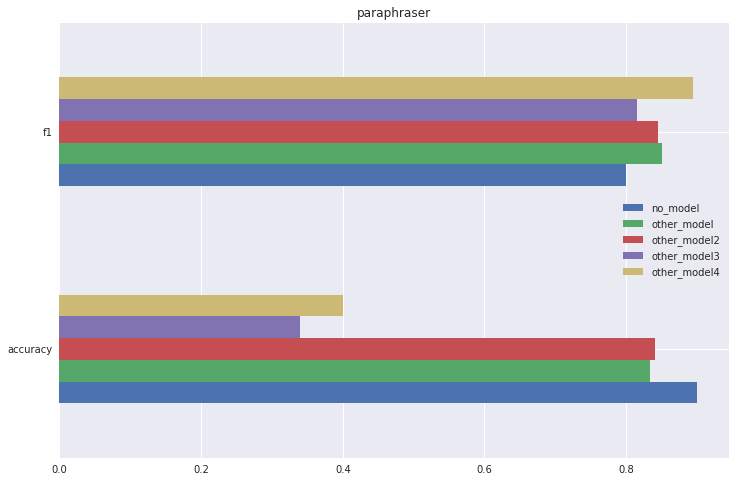

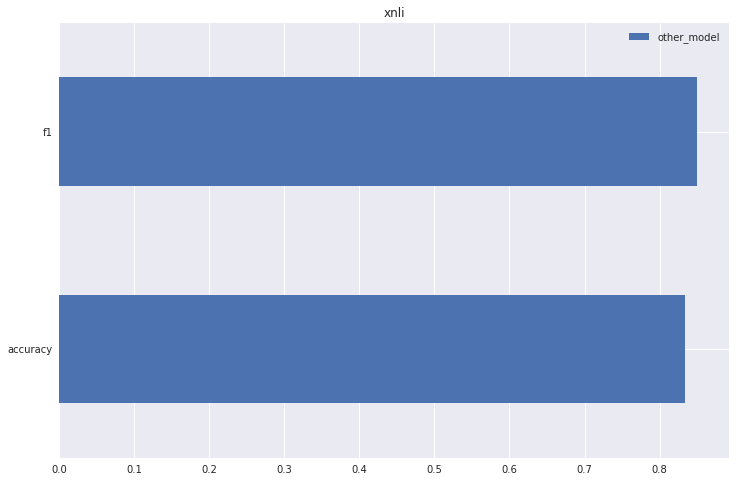

In [80]:
import matplotlib.pyplot as plt
import seaborn

seaborn.set()
%matplotlib inline

for i, task in enumerate(tasks):
    all_task_results = [x for x in results if x['task'] == task]
    if not all_task_results:
        continue
    to_plot = {res['model']: res['metrics'] for res in all_task_results}
    ax = pd.DataFrame(to_plot).plot(kind='barh', figsize=(12, 8), title=task)

plt.show()